# Playground for the rating prediction

### Import the data

In [142]:
import os
import pandas as pd

def import_data():
    try:
        path = os.path.join(os.getcwd() + "/data/cleaned_data.csv")
        df = pd.read_csv(path, index_col=0)
        print("Data imported sucessfully.")
        return df
    except Exception as e:
        print(f"Cannot import data: {e}")
        return None
    
df = import_data()
df.head()

df = df.sample(frac=0.1, random_state=10)

Data imported sucessfully.


In [143]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorizing the cleaned text
vectorizer = TfidfVectorizer(max_features=5000)  # Limiting to top 5000 features
X = vectorizer.fit_transform(df["text"]).toarray()

# Target variable (ratings)
y = df["rating"]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Tf-idf Logistic regression & Random forest

In [144]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)


# Evaluation
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

from sklearn.metrics import confusion_matrix, accuracy_score

# Evaluate Logistic Regression
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)
print("Accuracy for Logistic Regression:", accuracy_score(y_test, y_pred_lr))

# Evaluate Random Forest
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print("Accuracy for Random Forest:", accuracy_score(y_test, y_pred_rf))



Logistic Regression Classification Report:
              precision    recall  f1-score   support

         1.0       0.38      0.46      0.42        54
         2.0       0.45      0.42      0.43        71
         3.0       0.27      0.24      0.25        67
         4.0       0.36      0.36      0.36        70
         5.0       0.61      0.61      0.61        77

    accuracy                           0.42       339
   macro avg       0.41      0.42      0.41       339
weighted avg       0.42      0.42      0.42       339

Random Forest Classification Report:
              precision    recall  f1-score   support

         1.0       0.41      0.61      0.49        54
         2.0       0.38      0.37      0.37        71
         3.0       0.30      0.18      0.22        67
         4.0       0.37      0.31      0.34        70
         5.0       0.55      0.65      0.60        77

    accuracy                           0.42       339
   macro avg       0.40      0.42      0.40       3

### Confusion matrices

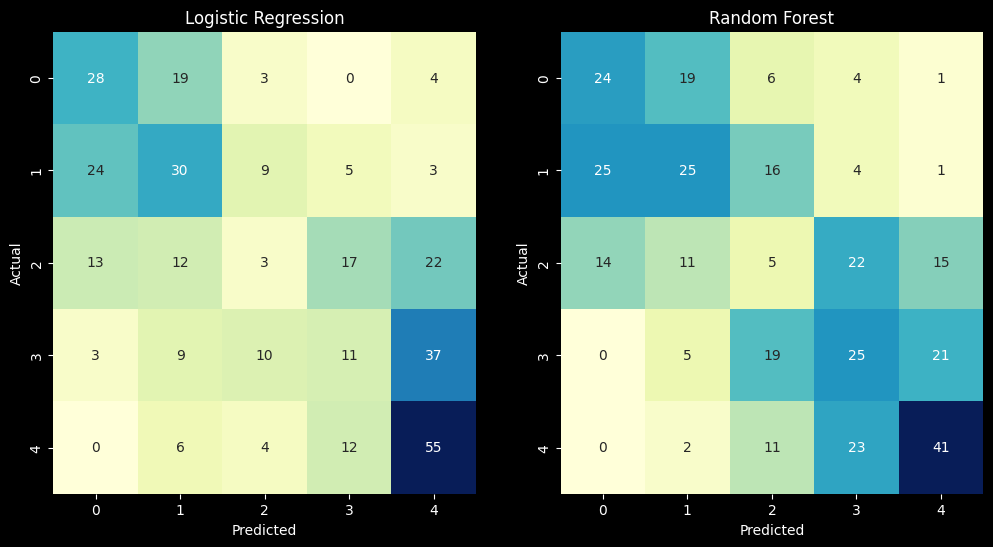

In [179]:

import matplotlib.pyplot as plt
import seaborn as sns

# Create a matplotlib figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot confusion matrix for Logistic Regression
sns.heatmap(conf_matrix_lr, annot=True, fmt="d",cmap="YlGnBu", cbar=False, ax=axes[0])
axes[0].set_title("Logistic Regression")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# Plot confusion matrix for Random Forest
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="YlGnBu", cbar=False, ax=axes[1])
axes[1].set_title("Random Forest")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

# Show the plot
plt.savefig("media/TF-IDF.png")

In [146]:
import pickle 

models = {'vectorizer':vectorizer ,'tfidf_logistic_regression_model': lr_model}

# Save the models using pickle
with open("models/tfidf_logistic_regression_model.pkl", "wb") as f:
    pickle.dump(models, f)

### Class predicted density

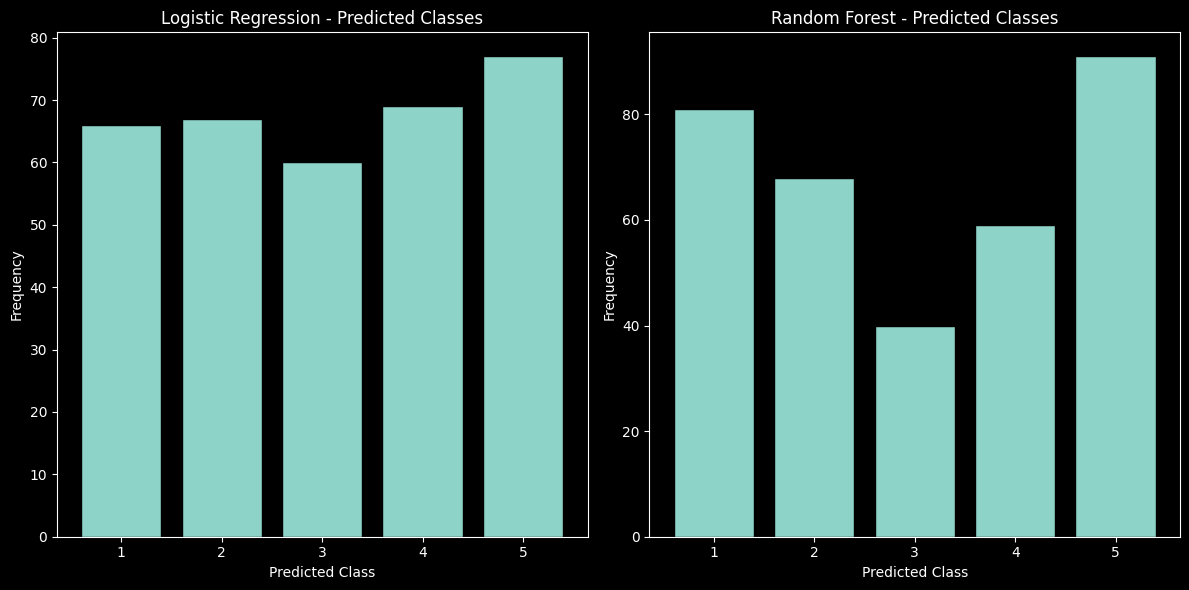

In [147]:

# Create a matplotlib figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot distribution of predicted classes for Logistic Regression
axes[0].hist(y_pred_lr, bins=range(1, 7), edgecolor='black', align='left', rwidth=0.8)
axes[0].set_title("Logistic Regression - Predicted Classes")
axes[0].set_xlabel("Predicted Class")
axes[0].set_ylabel("Frequency")

# Plot distribution of predicted classes for Random Forest
axes[1].hist(y_pred_rf, bins=range(1, 7), edgecolor='black', align='left', rwidth=0.8)
axes[1].set_title("Random Forest - Predicted Classes")
axes[1].set_xlabel("Predicted Class")
axes[1].set_ylabel("Frequency")

# Show the plot
plt.tight_layout()
plt.show()

## Hugging face roberta-base-go_emotions

In [148]:
import pandas as pd
from transformers import pipeline
from tqdm import tqdm  # Import tqdm

# Initialize the classifier
classifier = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=None)

# List to accumulate filtered results for the DataFrame
all_filtered_results = []

# Get the sentences from the 'text' column and corresponding 'note' column of the 'train' DataFrame
sentences = df["text"]
notes = df["rating"]

# Loop through the sentences with tqdm to show the progress bar
for sentence in tqdm(sentences, desc="Processing Sentences", unit="sentence"):
    # Get model outputs with truncation and max_length parameters
    model_outputs = classifier([sentence], truncation=True, max_length=512)

    result_dict = {}
    # Filter the results and store only the scores for the labels
    for item in model_outputs[0]:
        if item['label']:
            result_dict[item['label']] = item['score']

    # Append the result for this sentence to the list
    all_filtered_results.append(result_dict)

# Convert the accumulated results to a DataFrame
df_result = pd.DataFrame(all_filtered_results)

# Print the DataFrame
print(df_result)

Device set to use mps:0
Processing Sentences: 100%|██████████| 1691/1691 [01:09<00:00, 24.34sentence/s]

      approval  admiration   neutral  confusion  curiosity  optimism  \
0     0.380713    0.221408  0.113505   0.104978   0.095989  0.041299   
1     0.127841    0.035344  0.380678   0.001164   0.001744  0.035055   
2     0.010224    0.008296  0.180118   0.020878   0.047377  0.007195   
3     0.045930    0.242148  0.007695   0.001528   0.001246  0.008140   
4     0.193421    0.014574  0.244934   0.001727   0.001471  0.048211   
...        ...         ...       ...        ...        ...       ...   
1686  0.027682    0.002859  0.342395   0.002983   0.003835  0.012482   
1687  0.022146    0.002990  0.069947   0.005549   0.001788  0.003336   
1688  0.519620    0.038754  0.153383   0.001745   0.001373  0.029533   
1689  0.066687    0.003342  0.607072   0.001898   0.000810  0.014368   
1690  0.015138    0.001905  0.058386   0.006219   0.004264  0.005355   

      disapproval  annoyance  gratitude    caring  ...       joy     pride  \
0        0.032707   0.010219   0.008862  0.008058  ...  0

In [149]:
from sklearn.preprocessing import MinMaxScaler

# Initialize Min-Max Scaler
scaler = MinMaxScaler()

# Fit and transform the training data
df_scaled = scaler.fit_transform(df_result)


In [150]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_scaled,notes, test_size=0.2, random_state=42)

In [151]:

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# Random Forest
model = RandomForestClassifier(max_depth = 10, max_features = 'sqrt',min_samples_leaf= 4,min_samples_split= 10, n_estimators= 300)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluation
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

from sklearn.metrics import confusion_matrix, accuracy_score

# Evaluate Logistic Regression
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)
print("Accuracy for Logistic Regression:", accuracy_score(y_test, y_pred_lr))
print("Confusion Matrix for Logistic Regression:")
print(conf_matrix_lr)

# Evaluate Random Forest
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print("Accuracy for Random Forest:", accuracy_score(y_test, y_pred_rf))
print("Confusion Matrix for Random Forest:")
print(conf_matrix_rf)



Logistic Regression Classification Report:
              precision    recall  f1-score   support

         1.0       0.41      0.52      0.46        54
         2.0       0.39      0.42      0.41        71
         3.0       0.10      0.04      0.06        67
         4.0       0.24      0.16      0.19        70
         5.0       0.45      0.71      0.56        77

    accuracy                           0.37       339
   macro avg       0.32      0.37      0.34       339
weighted avg       0.32      0.37      0.34       339

Random Forest Classification Report:
              precision    recall  f1-score   support

         1.0       0.38      0.44      0.41        54
         2.0       0.40      0.35      0.38        71
         3.0       0.09      0.07      0.08        67
         4.0       0.32      0.36      0.34        70
         5.0       0.52      0.53      0.53        77

    accuracy                           0.35       339
   macro avg       0.34      0.35      0.35       3

In [152]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# Initialize the Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42,class_weight='balanced')

# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
    'max_features': [None, 'sqrt', 'log2'],
    'class_weight': [None, 'balanced']
}

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, 
                           scoring='accuracy', cv=5, verbose=0, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters and estimator
print("Best Parameters:", grid_search.best_params_)
best_dt = grid_search.best_estimator_

# Evaluate the model
y_pred_dt = best_dt.predict(X_test)

conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
print("Accuracy for Decision Tree:", accuracy_score(y_test, y_pred_dt))
print("Confusion Matrix for Decision Tree:")
print(conf_matrix_dt)

Best Parameters: {'class_weight': 'balanced', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 2}
Accuracy for Decision Tree: 0.3805309734513274
Confusion Matrix for Decision Tree:
[[30 15  4  1  4]
 [31 23 10  4  3]
 [12 12  9 13 21]
 [ 4  2 19 14 31]
 [ 2  1 10 11 53]]


In [153]:
from sklearn.svm import SVC

# Initialize and fit Support Vector Classifier
svm = SVC(random_state=42)
svm.fit(X_train, y_train)

SVC(random_state=42)

In [154]:

y_pred_svm = svm.predict(X_test)

# Evaluation
print("SVC Classification Report:")
print(classification_report(y_test, y_pred_svm))

# Evaluate SVM
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
print("Accuracy for SVC:", accuracy_score(y_test, y_pred_svm))
print("Confusion Matrix for SVC:")
print(conf_matrix_svm)


SVC Classification Report:
              precision    recall  f1-score   support

         1.0       0.49      0.39      0.43        54
         2.0       0.41      0.58      0.48        71
         3.0       0.12      0.06      0.08        67
         4.0       0.26      0.19      0.22        70
         5.0       0.45      0.66      0.53        77

    accuracy                           0.38       339
   macro avg       0.35      0.37      0.35       339
weighted avg       0.34      0.38      0.35       339

Accuracy for SVC: 0.3834808259587021
Confusion Matrix for SVC:
[[21 24  4  2  3]
 [13 41  8  3  6]
 [ 8 18  4 16 21]
 [ 1 11 12 13 33]
 [ 0  6  4 16 51]]


In [155]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize and fit Gradient Boosting Classifier
gb = GradientBoostingClassifier(random_state=42)

gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_test)

# Evaluation
print("Gradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_gb))

conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)
print("Confusion Matrix for Gradient Boosting Classification:")
print(conf_matrix_gb)


Gradient Boosting Classification Report:
              precision    recall  f1-score   support

         1.0       0.38      0.39      0.39        54
         2.0       0.39      0.39      0.39        71
         3.0       0.18      0.15      0.16        67
         4.0       0.36      0.37      0.36        70
         5.0       0.46      0.51      0.48        77

    accuracy                           0.37       339
   macro avg       0.35      0.36      0.36       339
weighted avg       0.36      0.37      0.36       339

Confusion Matrix for Gradient Boosting Classification:
[[21 21  8  3  1]
 [27 28  8  4  4]
 [ 7 15 10 16 19]
 [ 0  6 16 26 22]
 [ 0  1 13 24 39]]


In [156]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize and fit K-Nearest Neighbors Classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)

# Report
print("K-Nearest Neighbors Classification Report:")
print(classification_report(y_test, y_pred_knn))

# Evaluate KNN
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
print("Confusion Matrix for K-Nearest Neighbors:")
print(conf_matrix_knn)

K-Nearest Neighbors Classification Report:
              precision    recall  f1-score   support

         1.0       0.32      0.48      0.38        54
         2.0       0.39      0.34      0.36        71
         3.0       0.15      0.13      0.14        67
         4.0       0.30      0.31      0.31        70
         5.0       0.51      0.42      0.46        77

    accuracy                           0.33       339
   macro avg       0.33      0.34      0.33       339
weighted avg       0.34      0.33      0.33       339

Confusion Matrix for K-Nearest Neighbors:
[[26 18  6  2  2]
 [33 24  9  3  2]
 [15 12  9 22  9]
 [ 5  6 19 22 18]
 [ 3  1 17 24 32]]


### Results

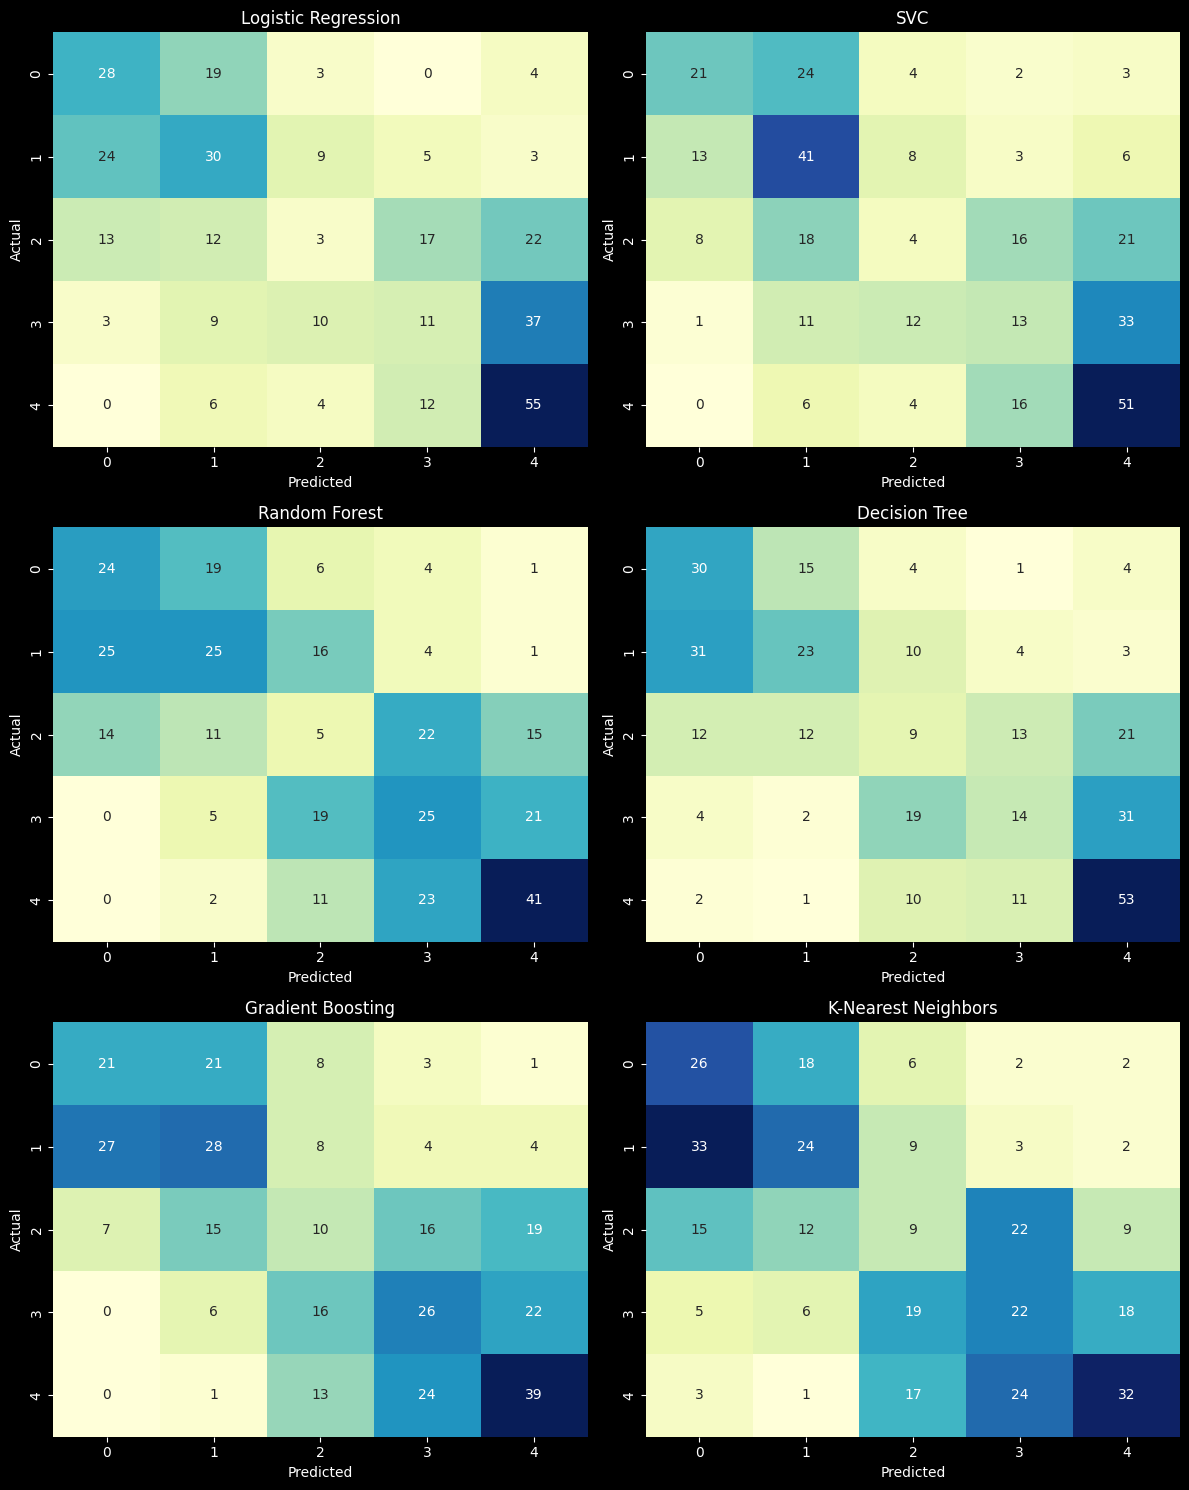

In [178]:

import matplotlib.pyplot as plt
import seaborn as sns

# Create a matplotlib figure with 1 row and 2 columns
fig, axes = plt.subplots(3, 2, figsize=(12, 15))

# Plot confusion matrix for Logistic Regression
sns.heatmap(conf_matrix_lr, annot=True, cmap="YlGnBu", fmt="d",cbar=False, ax=axes[0, 0])
axes[0,0].set_title("Logistic Regression")
axes[0,0].set_xlabel("Predicted")
axes[0,0].set_ylabel("Actual")

# Plot confusion matrix for Random Forest
sns.heatmap(conf_matrix_rf, annot=True, cmap="YlGnBu", fmt="d",cbar=False,  ax=axes[1 , 0])
axes[1,0].set_title("Random Forest")
axes[1,0].set_xlabel("Predicted")
axes[1,0].set_ylabel("Actual")

# Plot confusion matrix for Random Forest
sns.heatmap(conf_matrix_svm, annot=True, cmap="YlGnBu", fmt="d",cbar=False,  ax=axes[0,1])
axes[0 , 1].set_title("SVC")
axes[0 , 1].set_xlabel("Predicted")
axes[0 , 1].set_ylabel("Actual")

# Plot confusion matrix for Random Forest
sns.heatmap(conf_matrix_dt, annot=True,cmap="YlGnBu", fmt="d",cbar=False,  ax=axes[1,1])
axes[1,1].set_title("Decision Tree")
axes[1,1].set_xlabel("Predicted")
axes[1,1].set_ylabel("Actual")

# Plot confusion matrix for Random Forest
sns.heatmap(conf_matrix_gb, annot=True, cmap="YlGnBu", fmt="d",cbar=False,  ax=axes[2,0])
axes[2, 0].set_title("Gradient Boosting")
axes[2, 0].set_xlabel("Predicted")
axes[2, 0].set_ylabel("Actual")

# Plot confusion matrix for Random Forest
sns.heatmap(conf_matrix_knn, annot=True, cmap="YlGnBu", fmt="d",cbar=False, ax=axes[2,1])
axes[2, 1].set_title("K-Nearest Neighbors")
axes[2, 1].set_xlabel("Predicted")
axes[2, 1].set_ylabel("Actual")

plt.tight_layout()
# Show the plot
plt.savefig("media/Roberta.png")

In [158]:
import pickle

# Assuming your two models are `model1` and `model2`
models = {'classifier': classifier, 'random_forest': rf_model}

# Save the models using pickle
with open("models/huggingface_randomforest_model.pkl", "wb") as f:
    pickle.dump(models, f)

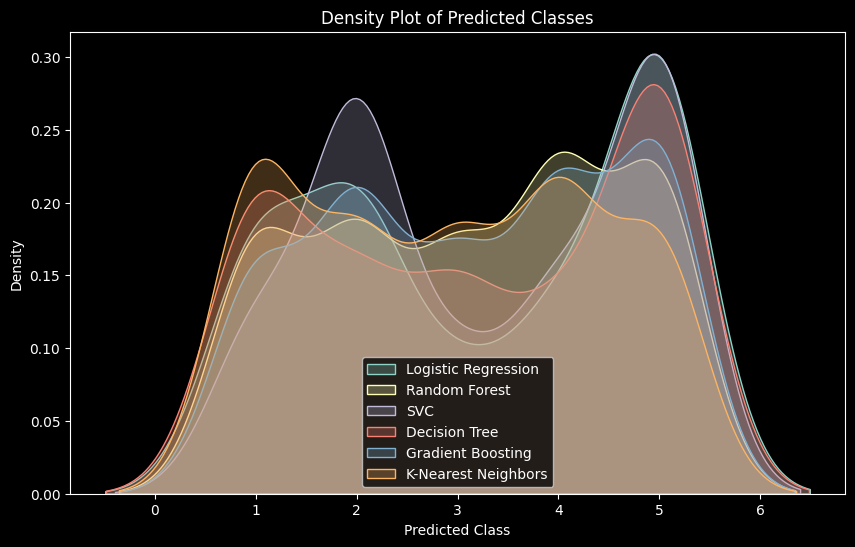

In [159]:
import seaborn as sns

import matplotlib.pyplot as plt

# Create a matplotlib figure
plt.figure(figsize=(10, 6))

# Plot density for Logistic Regression predicted classes
sns.kdeplot(y_pred_lr, label='Logistic Regression', fill=True)

# Plot density for Random Forest predicted classes
sns.kdeplot(y_pred_rf, label='Random Forest', fill=True)

# Plot density for SVM predicted classes
sns.kdeplot(y_pred_svm, label='SVC', fill=True)

# Plot density for SVM predicted classes
sns.kdeplot(y_pred_dt, label='Decision Tree', fill=True)

# Plot density for SVM predicted classes
sns.kdeplot(y_pred_gb, label='Gradient Boosting', fill=True)

# Plot density for SVM predicted classes
sns.kdeplot(y_pred_knn, label='K-Nearest Neighbors', fill=True)

# Add title and labels
plt.title('Density Plot of Predicted Classes')
plt.xlabel('Predicted Class')
plt.ylabel('Density')
plt.legend()

# Show the plot
plt.show()

In [160]:
import os


import openai

# Ensure that the OpenAI API key is accessible
openai.api_key = os.getenv("OPENAI_API_KEY")

## Hugging face multilingual-sentiment-analysis

In [161]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

model_name = "tabularisai/multilingual-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

def predict_sentiment(texts):
    inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
    sentiment_map = {0: "Very Negative", 1: "Negative", 2: "Neutral", 3: "Positive", 4: "Very Positive"}
    return [sentiment_map[p] for p in torch.argmax(probabilities, dim=-1).tolist()]

texts = df["text"].to_list()

notes = df["rating"]
sentiment_rating_map = {"Very Negative": 1.0, "Negative": 2.0, "Neutral": 3.0, "Positive": 4.0,  "Very Positive": 5.0}
all_filtered_results = []
for text in tqdm(texts, desc="Processing Sentences", unit="sentence"):
    feeling = {"predicted_feeling" : predict_sentiment(text)[0]}
    rating_dict = {"predicted_rating" : sentiment_rating_map[feeling["predicted_feeling"]]}

    all_filtered_results.append(rating_dict)

# Convert the accumulated results to a DataFrame
df_result = pd.DataFrame(all_filtered_results)

# Print the DataFrame
print(df_result)

Processing Sentences: 100%|██████████| 1691/1691 [00:39<00:00, 42.39sentence/s]

      predicted_rating
0                  5.0
1                  4.0
2                  3.0
3                  4.0
4                  1.0
...                ...
1686               3.0
1687               5.0
1688               4.0
1689               5.0
1690               1.0

[1691 rows x 1 columns]


In [162]:
# Evaluate SVM
conf_matrix = confusion_matrix(notes, df_result)
print("Accuracy for SVM:", accuracy_score(notes, df_result))
print("Confusion Matrix for SVM:")
print(conf_matrix)

Accuracy for SVM: 0.37670017740981665
Confusion Matrix for SVM:
[[173  62  51   5  37]
 [152  57  79  18  38]
 [ 62  36  86 105  35]
 [  7  11  58 189  72]
 [  6   7  33 180 132]]


## Hugging face zero-shot-classification

In [163]:
from transformers import pipeline
from tqdm import tqdm  
classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli")

sentiment_rating_map = {"Very Negative": 1.0, "Negative": 2.0, "Neutral": 3.0, "Positive": 4.0,  "Very Positive": 5.0}
all_filtered_results= []
for text in tqdm(texts, desc="Processing Sentences", unit="sentence"):
    result = classifier(text, candidate_labels=["Very Negative", "Negative", "Neutral", "Positive", "Very Positive"])

    rating_dict = {"predicted_rating" : sentiment_rating_map[result['labels'][0]]}
    all_filtered_results.append(rating_dict)

# Convert the accumulated results to a DataFrame
df_result = pd.DataFrame(all_filtered_results)

# Print the DataFrame
print(df_result)

Device set to use mps:0
Processing Sentences: 100%|██████████| 1691/1691 [05:55<00:00,  4.76sentence/s]

      predicted_rating
0                  5.0
1                  5.0
2                  2.0
3                  5.0
4                  2.0
...                ...
1686               4.0
1687               1.0
1688               5.0
1689               1.0
1690               2.0

[1691 rows x 1 columns]


In [164]:
conf_matrix = confusion_matrix(notes, df_result)
print("Accuracy for facebook/bart-large-mnli:", accuracy_score(notes, df_result))
print("Confusion Matrix for facebook/bart-large-mnli:")
print(conf_matrix)

Accuracy for facebook/bart-large-mnli: 0.43938497930218806
Confusion Matrix for facebook/bart-large-mnli:
[[155 149   1  13  10]
 [130 170   6  27  11]
 [ 34 108   5 116  61]
 [  1  19   4 178 135]
 [  1  10   4 108 235]]


In [165]:
import numpy as np
all_filtered_results= []
all_scores = []
for text in tqdm(texts, desc="Processing Sentences", unit="sentence"):
    result = classifier(text, candidate_labels =["Very Negative", "Negative", "Neutral", "Positive", "Very Positive"])
    scores = result['scores']
    labels = result['labels']
    predicted_label = labels[np.argmax(scores)]
    all_scores.append({label: score for label, score in zip(labels, scores)})

    sentiment_rating_map = {"Very Negative": 1.0, "Negative": 2.0, "Neutral": 3.0, "Positive": 4.0,  "Very Positive": 5.0}
    predicted_rating = sentiment_rating_map[predicted_label]

    all_filtered_results.append(predicted_rating)


# Convert the accumulated results to a DataFrame
df_result = pd.DataFrame(all_filtered_results)
df_scores = pd.DataFrame(all_scores)

Processing Sentences: 100%|██████████| 1691/1691 [09:47<00:00,  2.88sentence/s]


In [166]:
conf_matrix = confusion_matrix(notes, df_result)
print("Accuracy for SVM:", accuracy_score(notes, df_result))
print("Confusion Matrix for SVM:")
print(conf_matrix)

Accuracy for SVM: 0.43938497930218806
Confusion Matrix for SVM:
[[155 149   1  13  10]
 [130 170   6  27  11]
 [ 34 108   5 116  61]
 [  1  19   4 178 135]
 [  1  10   4 108 235]]


In [167]:
df_scores["True rating"] = notes.to_list()
df_scores

,Very Positive,Positive,Neutral,Negative,Very Negative,True rating
0,0.717208,0.258350,0.013581,0.008037,0.002825,5.0
1,0.565848,0.429179,0.003208,0.000911,0.000855,5.0
2,0.025957,0.030628,0.055559,0.500750,0.387105,2.0
3,0.641873,0.334669,0.017904,0.003658,0.001897,4.0
4,0.021623,0.048918,0.044763,0.559946,0.324750,2.0
...,...,...,...,...,...,...
1686,0.053107,0.733370,0.043569,0.090316,0.079637,2.0
1687,0.011190,0.012445,0.024380,0.228054,0.723931,1.0
1688,0.516020,0.463752,0.015170,0.003334,0.001724,4.0
1689,0.016684,0.028348,0.063522,0.432369,0.459077,2.0


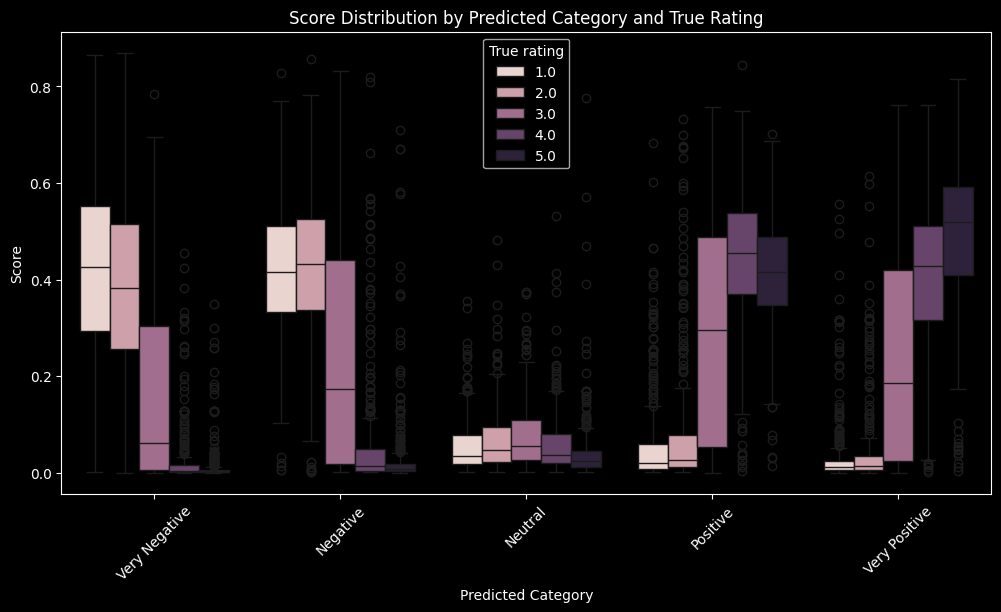

In [168]:
df_melted = df_scores.melt(
    id_vars=["True rating"],
    value_vars=["Very Negative", "Negative", "Neutral", "Positive", "Very Positive"],
    var_name="Predicted Category",
    value_name="Score",
)

# Plot score distributions
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_melted, x="Predicted Category", y="Score", hue="True rating")
plt.title("Score Distribution by Predicted Category and True Rating")
plt.xticks(rotation=45)
plt.show()

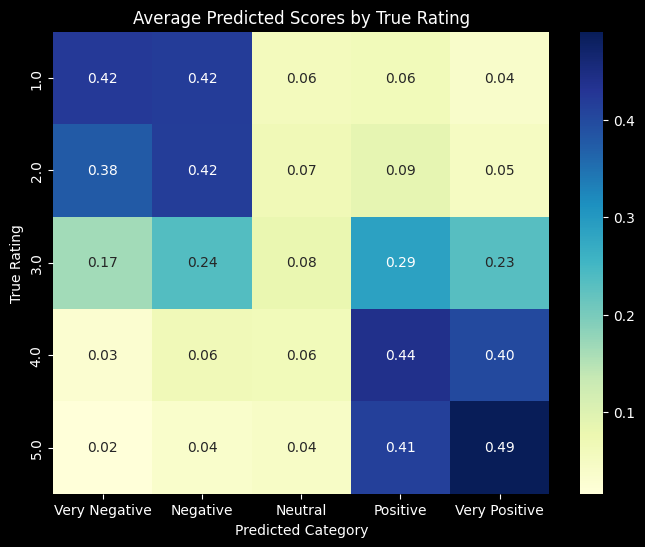

In [169]:
# Compute the mean score for each predicted category grouped by true rating
heatmap_data = df_scores.groupby("True rating")[
    ["Very Negative", "Negative", "Neutral", "Positive", "Very Positive"]
].mean()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True)
plt.title("Average Predicted Scores by True Rating")
plt.xlabel("Predicted Category")
plt.ylabel("True Rating")
plt.savefig("media/Zeroshot_BART.png")
plt.show()

In [170]:
conf_matrix = confusion_matrix(notes, df_result)
print("Accuracy for facebook/bart-large-mnli:", accuracy_score(notes, df_result))
print("Confusion Matrix for facebook/bart-large-mnli:")
print(conf_matrix)

Accuracy for facebook/bart-large-mnli: 0.43938497930218806
Confusion Matrix for facebook/bart-large-mnli:
[[155 149   1  13  10]
 [130 170   6  27  11]
 [ 34 108   5 116  61]
 [  1  19   4 178 135]
 [  1  10   4 108 235]]


# Playground for sentiment analysis

In [171]:

from tqdm import tqdm
from transformers import pipeline
classifier = pipeline("zero-shot-classification", model="MoritzLaurer/mDeBERTa-v3-base-mnli-xnli")

all_filtered_results= []
all_scores = []
for text in tqdm(texts, desc="Processing Sentences", unit="sentence"):
    result = classifier(text, ["Positive", "Neutral", "Negative"], multi_label=False)
    scores = result['scores']
    labels = result['labels']
    predicted_label = labels[np.argmax(scores)]
    all_scores.append({label: score for label, score in zip(labels, scores)})



# Convert the accumulated results to a DataFrame
df_result = pd.DataFrame(all_filtered_results)
df_scores = pd.DataFrame(all_scores)
df_scores["True rating"] = notes.to_list()
df_scores

Device set to use mps:0
Processing Sentences: 100%|██████████| 1691/1691 [09:19<00:00,  3.02sentence/s]  


,Positive,Neutral,Negative,True rating
0,0.723556,0.144437,0.132006,5.0
1,0.834714,0.136735,0.028551,5.0
2,0.214388,0.200552,0.585061,2.0
3,0.989748,0.006164,0.004088,4.0
4,0.304688,0.203226,0.492086,2.0
...,...,...,...,...
1686,0.591220,0.165021,0.243760,2.0
1687,0.014532,0.056139,0.929329,1.0
1688,0.982762,0.012560,0.004677,4.0
1689,0.173997,0.095945,0.730057,2.0


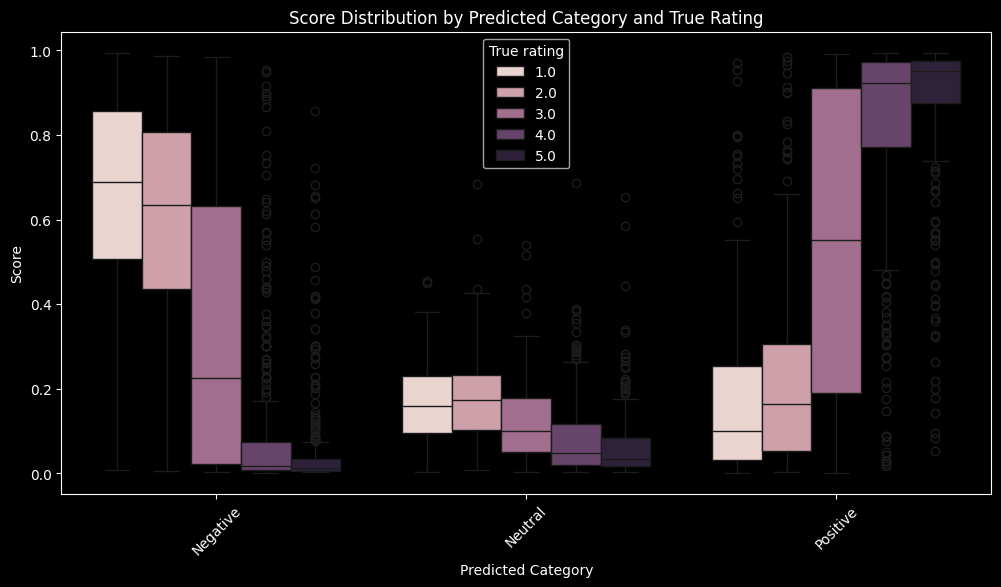

In [172]:
df_melted = df_scores.melt(
    id_vars=["True rating"],
    value_vars=["Negative", "Neutral", "Positive"],
    var_name="Predicted Category",
    value_name="Score",
)

# Plot score distributions
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_melted, x="Predicted Category", y="Score", hue="True rating")
plt.title("Score Distribution by Predicted Category and True Rating")
plt.xticks(rotation=45)
plt.show()

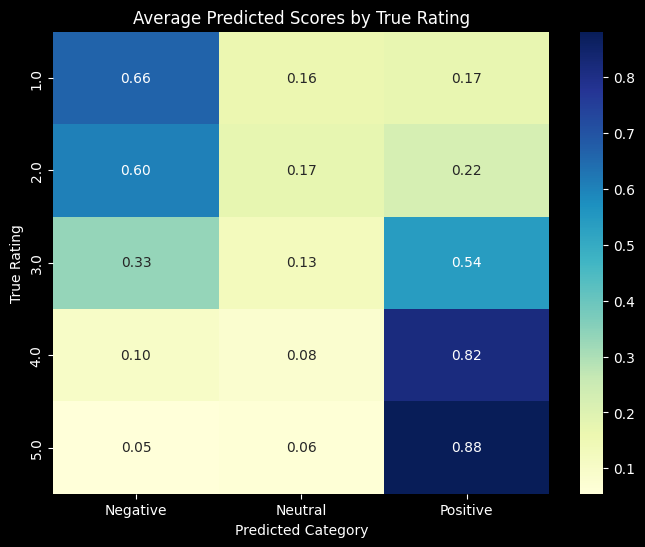

In [173]:
# Compute the mean score for each predicted category grouped by true rating
heatmap_data = df_scores.groupby("True rating")[
    ["Negative", "Neutral", "Positive"]
].mean()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True)
plt.title("Average Predicted Scores by True Rating")
plt.xlabel("Predicted Category")
plt.ylabel("True Rating")
plt.savefig("media/sentiment_analysis.png")
plt.show()